In [ ]:
import dolfinx
print(f"DOLFINx version: {dolfinx.__version__} based on GIT commit: {dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")

In [1]:
from mpi4py import MPI
import numpy as np
from petsc4py.PETSc import ScalarType
from dolfinx.fem.petsc import LinearProblem
from dolfinx import mesh, io, fem
from dolfinx.fem import Function, FunctionSpace, dirichletbc, locate_dofs_geometrical, form
import ufl
from ufl import grad, div, nabla_grad, dx, inner, dot, Measure, FacetNormal, SpatialCoordinate, TestFunctions, TrialFunctions, div, exp, inner

domain = mesh.create_unit_square(MPI.COMM_WORLD, 10, 10)

P2 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 2)
P1 = ufl.FiniteElement("Lagrange", domain.ufl_cell(), 1)
TH = P2 * P1
V = FunctionSpace(domain, TH)
(v_a, p_a) = TrialFunctions(V)
(v_t, p_t) = TestFunctions(V)

x = SpatialCoordinate(domain)
U = 1.0



In [2]:
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)


In [3]:
def u_exact(x):
    #x_array = np.array(x[0])
    #y_array = np.array(x[1])
    
    theta = np.arctan2(x[0], x[1])
    radius = (x[0]**2 + x[1]**2)**0.5
    Ue = -U
    theta0 = 0.5*np.pi
    f = Ue*(-theta0**2*np.sin(theta) + theta0*theta*np.sin(theta) \
           - np.sin(theta0)*np.cos(theta0)*theta*np.sin(theta) \
           + np.sin(theta0)**2*theta*np.cos(theta)) \
           /(theta0**2 - np.sin(theta0)**2)
    
    dfdt = Ue*(-theta0**2*np.cos(theta) + theta0*np.sin(theta) \
              + theta0*theta*np.cos(theta) - np.sin(theta0)*np.cos(theta0)*np.sin(theta) \
              - np.sin(theta0)*np.cos(theta0)*theta*np.cos(theta) \
              + np.sin(theta0)**2*np.cos(theta) - np.sin(theta0)**2*theta*np.sin(theta)) \
           /(theta0**2 - np.sin(theta0)**2)
    psie = radius*f
    vre = dfdt
    vte = -f
    ve = np.array([vre*np.cos(theta) - vte*np.sin(theta),
                   vre*np.sin(theta) + vte*np.cos(theta)])
    
    return ve


In [4]:
W0, _ = V.sub(0).collapse()
ve = Function(W0)
ve.interpolate(u_exact) 

In [5]:
ve.x.array

array([-0.00000000e+00,  0.00000000e+00, -1.61050550e-03, -6.53648887e-02,
       -0.00000000e+00,  0.00000000e+00, -1.77883333e-03, -6.86451939e-02,
       -0.00000000e+00,  0.00000000e+00, -6.04212826e-03, -1.24796223e-01,
       -6.64682208e-03, -1.30688413e-01, -1.97493739e-03, -7.22705613e-02,
       -0.00000000e+00,  0.00000000e+00, -1.26507852e-02, -1.77881844e-01,
       -7.34607619e-03, -1.37152184e-01, -2.20526572e-03, -7.62981391e-02,
       -0.00000000e+00,  0.00000000e+00, -1.38491197e-02, -1.85666599e-01,
       -2.07642851e-02, -2.24402182e-01, -8.16041244e-03, -1.44272334e-01,
       -2.47824575e-03, -8.07983389e-02, -2.26013286e-02, -2.33353132e-01,
       -1.52213460e-02, -1.94123396e-01, -0.00000000e+00,  0.00000000e+00,
       -2.97199456e-02, -2.64326500e-01, -1.68014410e-02, -2.03334304e-01,
       -9.11613424e-03, -1.52150506e-01, -2.46787799e-02, -2.42955947e-01,
       -2.80505786e-03, -8.58588827e-02, -0.00000000e+00,  0.00000000e+00,
       -3.21375280e-02, -

In [6]:
def Left(x):
        return np.isclose(x[0], 0)
def Bottom(x):
        return np.isclose(x[1], 0)
def TopRight(x):
        return np.logical_or(np.isclose(x[0], 1), np.isclose(x[1], 1))

dofs_TopRightBoundary = locate_dofs_geometrical(W0, TopRight)
dofs_SideBoundary = locate_dofs_geometrical(W0, Left)
dofs_BottomBoundary = locate_dofs_geometrical(W0, Bottom)

u_bc = Function(W0)
u_bc.interpolate(u_exact)
bc_Bottom = dirichletbc(u_bc, dofs_BottomBoundary)
bc_Side = dirichletbc(u_bc, dofs_SideBoundary)
bc_TopRight = dirichletbc(u_bc, dofs_TopRightBoundary)

n = FacetNormal(domain)

K = inner(ufl.sym(grad(v_t)), ufl.sym(grad(v_a)))*dx 
G = -div(v_t)*p_a*dx
D = -p_t*div(v_a)*dx
S=K+G+D
L = fem.Constant(domain, ScalarType(0.0)) * v_t[0] * dx

#f = T_t*rhsf*dx + T_t*inner(gN, n)*ds
problem = LinearProblem(S, L, bcs=[bc_Bottom, bc_Side, bc_TopRight], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
u_i = problem.solve()

u_i

Coefficient(FunctionSpace(Mesh(VectorElement(Basix element (P, triangle, 1, gll_warped, unset, False), 2), 0), MixedElement(VectorElement(FiniteElement('Lagrange', triangle, 2), dim=2), FiniteElement('Lagrange', triangle, 1))), 2)

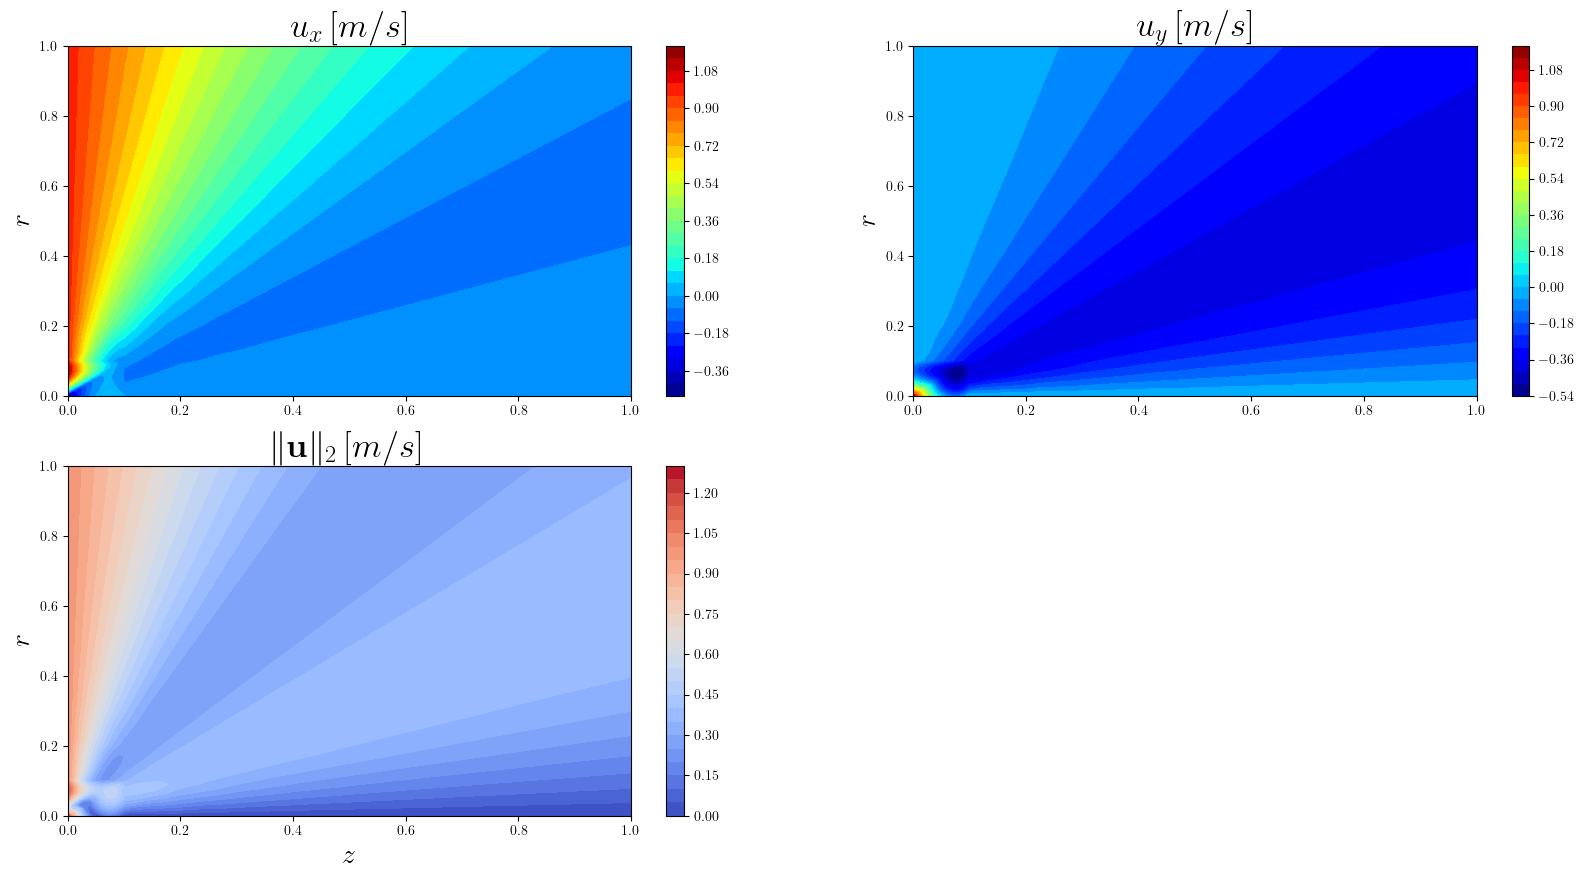

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm
from scipy.interpolate import NearestNDInterpolator
import dolfinx


plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = r'\usepackage{amssymb} \usepackage{amsmath} \usepackage{amsthm} \usepackage{mathtools}'

def extractVectorField(domain, xBound, yBound, ve):
    Nx, Ny = 100, 100
    x_grid = np.linspace(xBound[0], xBound[1], Nx)
    y_grid = np.linspace(yBound[0], yBound[1], Ny)
    
    u_x = np.zeros((Nx, Ny))
    u_y = np.zeros_like(u_x)

    for ii in range(Nx):
        points = np.zeros((3, Ny))
        points[0, :] = x_grid[ii]
        points[1, :] = y_grid

        bb_tree = dolfinx.geometry.BoundingBoxTree(domain, domain.topology.dim)
        cells = []
        points_on_proc = []
        cell_candidates = dolfinx.geometry.compute_collisions(bb_tree, points.T)
        colliding_cells = dolfinx.geometry.compute_colliding_cells(domain, cell_candidates, points.T)
        for i, point in enumerate(points.T):
            if len(colliding_cells.links(i))>0:
                points_on_proc.append(point)
                cells.append(colliding_cells.links(i)[0])
        xPlot = np.array(points_on_proc, dtype=np.float64)

        u_x[ii, :] = ve.eval(xPlot, cells)[:, 0]
        u_y[ii, :] = ve.eval(xPlot, cells)[:, 1]

    u_x_grid = np.zeros((Nx * Ny,))
    u_y_grid = np.zeros_like(u_x_grid)
    x_y_grid = np.zeros((Nx * Ny, 2))

    idx = 0

    for ii in range(Nx):
        for jj in range(Ny):
            u_x_grid[idx] = u_x[ii, jj]
            u_y_grid[idx] = u_y[ii, jj]

            x_y_grid[idx, 0] = x_grid[ii]
            x_y_grid[idx, 1] = y_grid[jj]

            idx += 1

    return NearestNDInterpolator(x_y_grid, u_x_grid), NearestNDInterpolator(x_y_grid, u_y_grid)


xBound = np.array([0., 1.])
yBound = np.array([0., 1.])
ux_fun, uy_fun = extractVectorField(domain, xBound, yBound, ve)


##############################################################################

xPlot = np.linspace(xBound[0], xBound[1], 100)
yPlot = np.linspace(yBound[0], yBound[1], 100)

X, Y = np.meshgrid(xPlot, yPlot)

_figure = plt.figure( figsize = (20,10) )
plt.subplot(2,2,1)
plt.contourf(X, Y, ux_fun(X,Y), cmap=cm.jet, levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.title(r'$u_x\,[m/s]$', fontsize = 25)
                         
plt.subplot(2,2,2)
plt.contourf(X, Y, uy_fun(X,Y), cmap=cm.jet, levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.title(r'$u_y\,[m/s]$', fontsize = 25)

plt.subplot(2,2,3)
plt.contourf(X, Y, np.sqrt(ux_fun(X,Y)**2 + uy_fun(X,Y)**2), cmap='coolwarm', levels = 30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize = 20)
plt.xlabel(r'$z$', fontsize = 20)
plt.title(r'$\|\mathbf{u}\|_2\,[m/s]$', fontsize = 25)

_figure.savefig('Stokes_blockDirect.pdf', format='pdf', dpi=600, bbox_inches='tight')

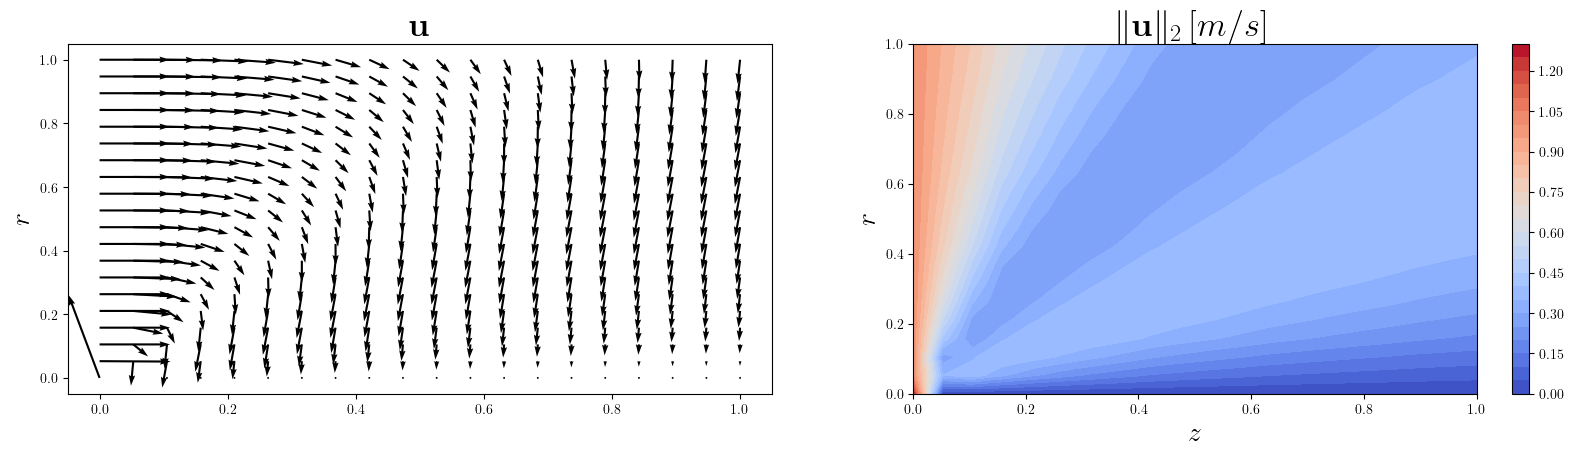

In [8]:
xPlot = np.linspace(xBound[0], xBound[1], 20)
yPlot = np.linspace(yBound[0], yBound[1], 20)

X, Y = np.meshgrid(xPlot, yPlot)

_figure = plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.quiver(X, Y, ux_fun(X, Y), uy_fun(X, Y), scale=10)
plt.ylabel(r'$r$', fontsize=20)
plt.title(r'$\mathbf{u}$', fontsize=25)

plt.subplot(2, 2, 2)
plt.contourf(X, Y, np.sqrt(ux_fun(X, Y)**2 + uy_fun(X, Y)**2), cmap='coolwarm', levels=30)
plt.colorbar()
plt.ylabel(r'$r$', fontsize=20)
plt.xlabel(r'$z$', fontsize=20)
plt.title(r'$\|\mathbf{u}\|_2\,[m/s]$', fontsize=25)

_figure.savefig('BatchelorCornerflow.pdf', format='pdf', dpi=600, bbox_inches='tight')


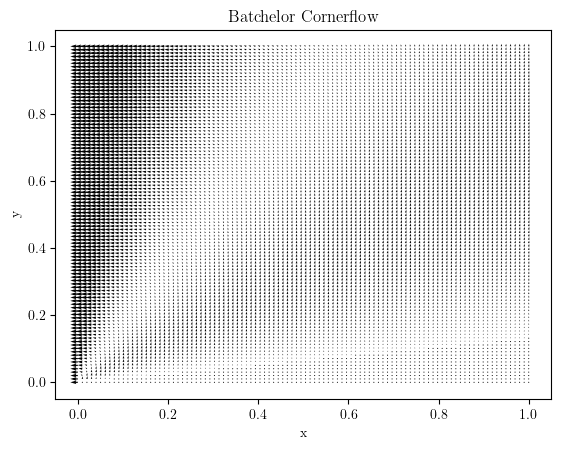

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Define the mesh coordinates
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x, y)

# Evaluate the velocity field at each mesh point
Ue = 1.0  # Define the velocity magnitude
theta0 = 0.5 * np.pi
theta = np.arctan2(X, Y)
radius = (X ** 2 + Y ** 2) ** 0.5
f = Ue * (-theta0 ** 2 * np.sin(theta) + theta0 * theta * np.sin(theta)
          - np.sin(theta0) * np.cos(theta0) * theta * np.sin(theta)
          + np.sin(theta0) ** 2 * theta * np.cos(theta)) / (theta0 ** 2 - np.sin(theta0) ** 2)

vre = Ue * (-theta0 ** 2 * np.cos(theta) + theta0 * np.sin(theta)
            + theta0 * theta * np.cos(theta) - np.sin(theta0) * np.cos(theta0) * np.sin(theta)
            - np.sin(theta0) * np.cos(theta0) * theta * np.cos(theta)
            + np.sin(theta0) ** 2 * np.cos(theta) - np.sin(theta0) ** 2 * theta * np.sin(theta)) \
      / (theta0 ** 2 - np.sin(theta0) ** 2)
vte = -f
ve = np.array([vre * np.cos(theta) - vte * np.sin(theta),
               vre * np.sin(theta) + vte * np.cos(theta)])

# Plot the velocity field
fig, ax = plt.subplots()
ax.quiver(X, Y, ve[0], ve[1])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Batchelor Cornerflow')
plt.show()
_figure.savefig('BatchelorCornerflow_subplots.pdf', format='pdf', dpi=600, bbox_inches='tight')
